# Ising Model Hamiltonian

$$ H = \sum_i X_i X_{i+1} + Y_i Y_{i+1} + \eta \sum_i Z_i $$

In [1]:
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [2]:
ETA = 0.5

Ising = qml.Hamiltonian(
    [1, 1, 1, 1, ETA, ETA, ETA],
    [
        qml.PauliX(0) @ qml.PauliX(1),
        qml.PauliY(0) @ qml.PauliY(1),
        qml.PauliX(1) @ qml.PauliX(2),
        qml.PauliY(1) @ qml.PauliY(2),
        qml.PauliZ(0),
        qml.PauliZ(1),
        qml.PauliZ(2),
    ],
)

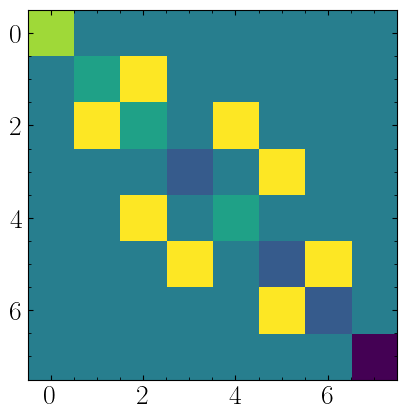

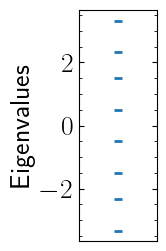

Ground state energy: -3.328


In [15]:
plt.imshow(qml.matrix(Ising).real)
plt.savefig("ising")
plt.show()

e, v = np.linalg.eigh(qml.matrix(Ising))
fig = plt.figure(figsize=(1, 3))
plt.scatter([0] * len(e), e, marker="_")
plt.xticks([])
plt.ylabel("Eigenvalues")
plt.show()

print(f"Ground state energy: {min(e):.3f}")

We will use simplified two design as ansatz: see [Cerezo et al. (2021)](https://doi.org/10.1038/s41467-021-21728-w) for details.

In [4]:
NLAYERS = 3
shapes = qml.SimplifiedTwoDesign.shape(NLAYERS, 3)

<Figure size 640x480 with 0 Axes>

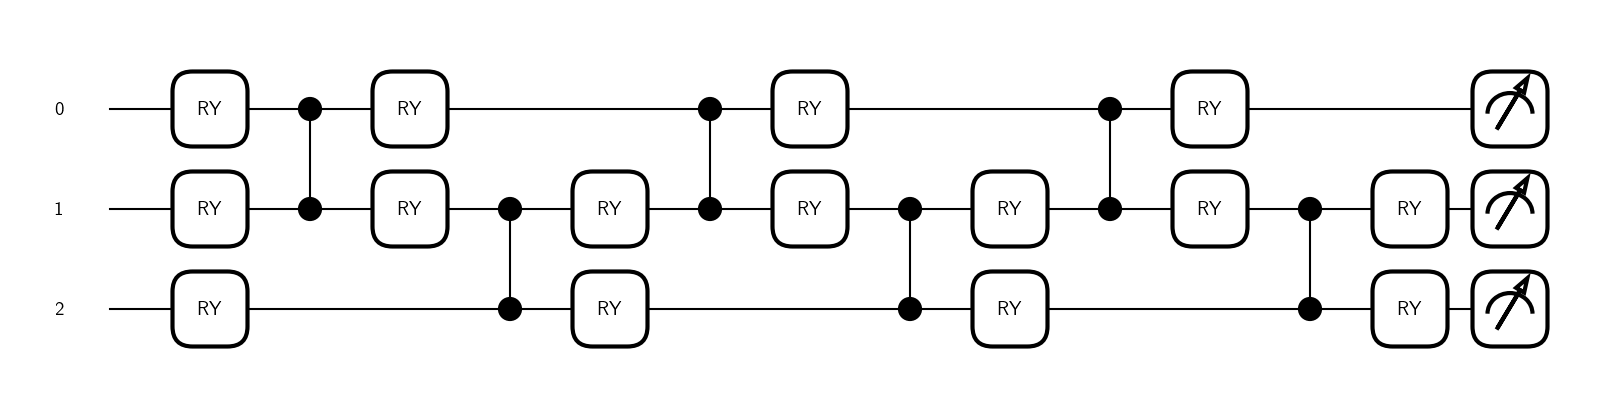

In [5]:
@qml.qnode(qml.device("default.qubit", wires=3))
def circuit(par1, par2):
    qml.SimplifiedTwoDesign(par1, par2, wires=range(3))
    return qml.expval(op=Ising)


fig = plt.figure()
qml.draw_mpl(circuit, expansion_strategy="device")(
    np.random.random(shapes[0]), np.random.random(shapes[1])
)
plt.savefig("ansatz")

In [8]:
gradient = qml.grad(circuit, argnum=[0, 1])


loss = []


def cost(pars):
    initials = pars[: np.prod(shapes[0])]
    weights = pars[np.prod(shapes[0]) :].reshape(shapes[1])

    expval = circuit(initials, weights)
    grad = gradient(initials, weights)

    loss.append(expval)
    return expval, np.hstack([grad[0], grad[1].reshape(np.prod(shapes[1]))])


pars = np.random.random(np.prod(shapes[0]) + np.prod(shapes[1]))

opt = scipy.optimize.minimize(
    cost,
    pars,
    method="SLSQP",
    jac=True,
    hess=None,
    bounds=None,
    constraints=None,
    tol=1e-4,
    options={"maxiter": 10000, "disp": True},
)

print(f"\n\nreconstructed ground state energy: {opt.fun:.3f}")

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.328426783082218
            Iterations: 13
            Function evaluations: 19
            Gradient evaluations: 13


reconstructed ground state energy: -3.328


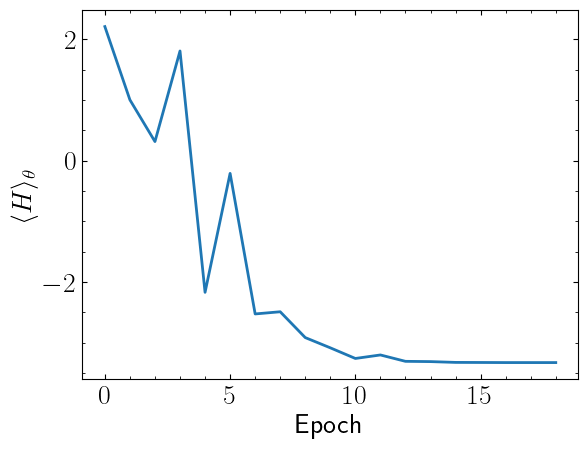

In [9]:
plt.plot(loss)
plt.ylabel(r"$\langle H \rangle_\theta$")
plt.xlabel("Epoch")
plt.savefig("loss")